# Group Project: Machine Learning 

- <a href='#part1'>Part 1: Deep L-Layer Neural Network for Image Classification</a>
	- You will use pre-built functions to build an L-Layer neural network for an image classification task
- <a href='#part2'>Part 2: Full Machine Learning Project</a>
	- You will go through the full "idea, code, experiment" cycle to build and improve a model of your choice

You may work in groups of 1-3 students for this project.

In this project, especially in Part 2, you are expected to show the work you have done in the form of including results for models you have experimented with on the path to the best-performing model. Make sure you include Python and markdown boxes explaining and discussing any decisions you have made and interpretations of the results you have achieved. You can include diagrams, tables, and/or graphs using markdown. **A significant portion of your grade will be based on the progression of your model, not just the final result.**

**Note**: All work you submit must be the work of your group. Projects will be checked against each other, and against any work submitted in previous semesters where a similar project was given.

<a id="part1"></a>
## Part 1: Deep L-Layer Neural Network for Image Classification

You will use the functions given to you to build a deep L-layer network, and apply it to cat vs non-cat classification. Hopefully, you will see an improvement in accuracy relative to your previous logistic regression implementation.  

### 1.1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [h5py](http://www.h5py.org) is a common package to interact with a dataset that is stored on an H5 file.
- [PIL](https://pillow.readthedocs.io/en/stable/index.html) and [scipy](https://www.scipy.org/) are used here to test your model with your own picture at the end.
- nn_functions provides the functions you need to build an L-layer network.
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work.

In [27]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from nn_functions import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

print("complete")
print("keras imported")
print("panda imported")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
complete
keras imported
panda imported


### 1.2 - Dataset

You will use the same "Cat vs non-Cat" dataset as in your previous assignment. The model you had built had 70% test accuracy on classifying cats vs non-cats images. Hopefully, your new model will perform a better!

**Problem Statement**: You are given a dataset containing:
- a training set of m_train images labelled as cat (1) or non-cat (0)
- a test set of m_test images labelled as cat and non-cat
- each image is of shape (num_px, num_px, 3) where 3 is for the 3 channels (RGB).

Let's get more familiar with the dataset. Load the data by running the cell below.

In [4]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

The following code will show you an image in the dataset. Feel free to change the index and re-run the cell multiple times to see other images. 

y = 1. It's a cat picture.


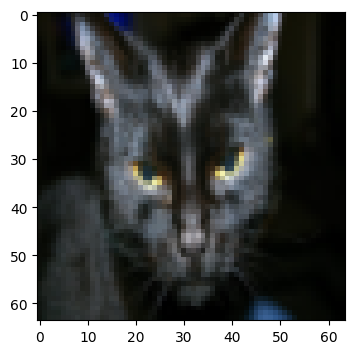

In [5]:
# Example of a picture
index = 25
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [6]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


As usual, you reshape and standardize the images before feeding them to the network. The code is given in the cell below.

<img src="images/imvectorkiank.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 1</u>: Image to vector conversion. <br> </center></caption>

In [7]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ equals $64 \times 64 \times 3$ which is the size of one reshaped image vector.

### 1.3 - Architecture of your model

Now that you are familiar with the dataset, it is time to build a deep neural network to distinguish cat images from non-cat images.

Here is a simplified network representation for an L-layer neural network:

<img src="images/LlayerNN_kiank.png" style="width:650px;height:400px;">
<caption><center> <u>Figure 2</u>: L-layer neural network.</center></caption> 

The model can be summarized as: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Detailed Architecture of figure 2</u>:
- The input is a (64,64,3) image which is flattened to a vector of size (12288,1).
- The corresponding vector: $[x_0,x_1,...,x_{12287}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, you take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, you take the sigmoid of the final linear unit. If it is greater than 0.5, you classify it to be a cat.

<u>General methodology</u>

As usual you will follow the Deep Learning methodology to build the model:
1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    - Forward propagation
    - Compute cost function
    - Backward propagation
    - Update parameters (using parameters, and grads from backprop) 
4. Use trained parameters to predict labels

### 1.4 - L-layer Neural Network

**Exercise**: Use the helper functions in the nn_functions file to build an $L$-layer neural network with the following structure: **[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID**. Spend some time looking through the functions and understanding how they can be used to build a deep neural network. The functions you may need and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [9]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    ### START CODE HERE ###
    
    parameters = initialize_parameters_deep(layers_dims)
    
    ### END CODE HERE ###
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # START CODE HERE ### (≈ 4 lines of code)
        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        ### END CODE HERE ###
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

You will now train the model as a 4-layer neural network. 

Run the cell below to train your model. The cost should decrease on every iteration. It may take a few minutes to run 2500 iterations. 

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


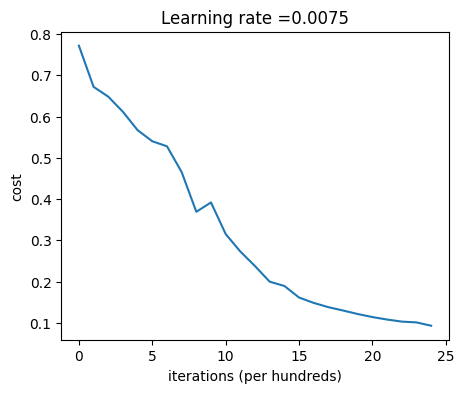

In [10]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

In [11]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


In [12]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


Congratulations! It seems that your 4-layer neural network has better performance than your previous assignment network on the same test set. 

This is good performance for this task.

###  1.5 - Results Analysis

First, let's take a look at some images the L-layer model labeled incorrectly. This will show a few mislabeled images. 

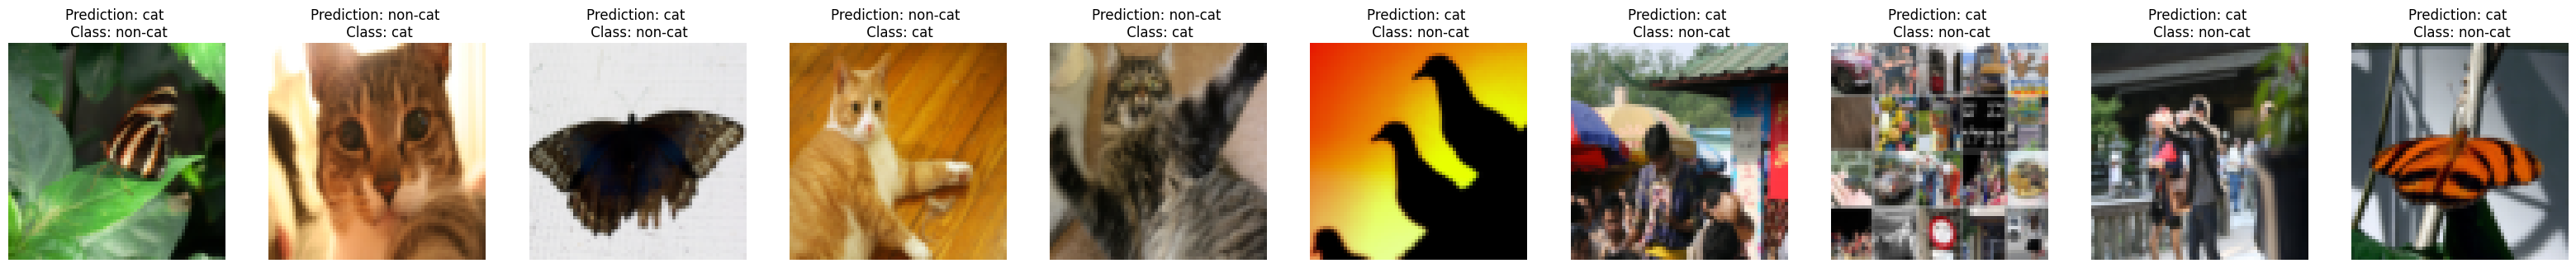

In [13]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**A few types of images the model tends to do poorly on include:** 
- Cat body in an unusual position
- Cat appears against a background of a similar color
- Unusual cat color and species
- Camera Angle
- Brightness of the picture
- Scale variation (cat is very large or small in image) 

### 1.6 - Test with your own image (optional/ungraded exercise) ##

You can use your own image and see the output of your model. To do that:
1. Add your image to the "images" folder
2. Change your image's name in the following code
3. Run the code and check if the algorithm is right (1 = cat, 0 = non-cat)!

Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


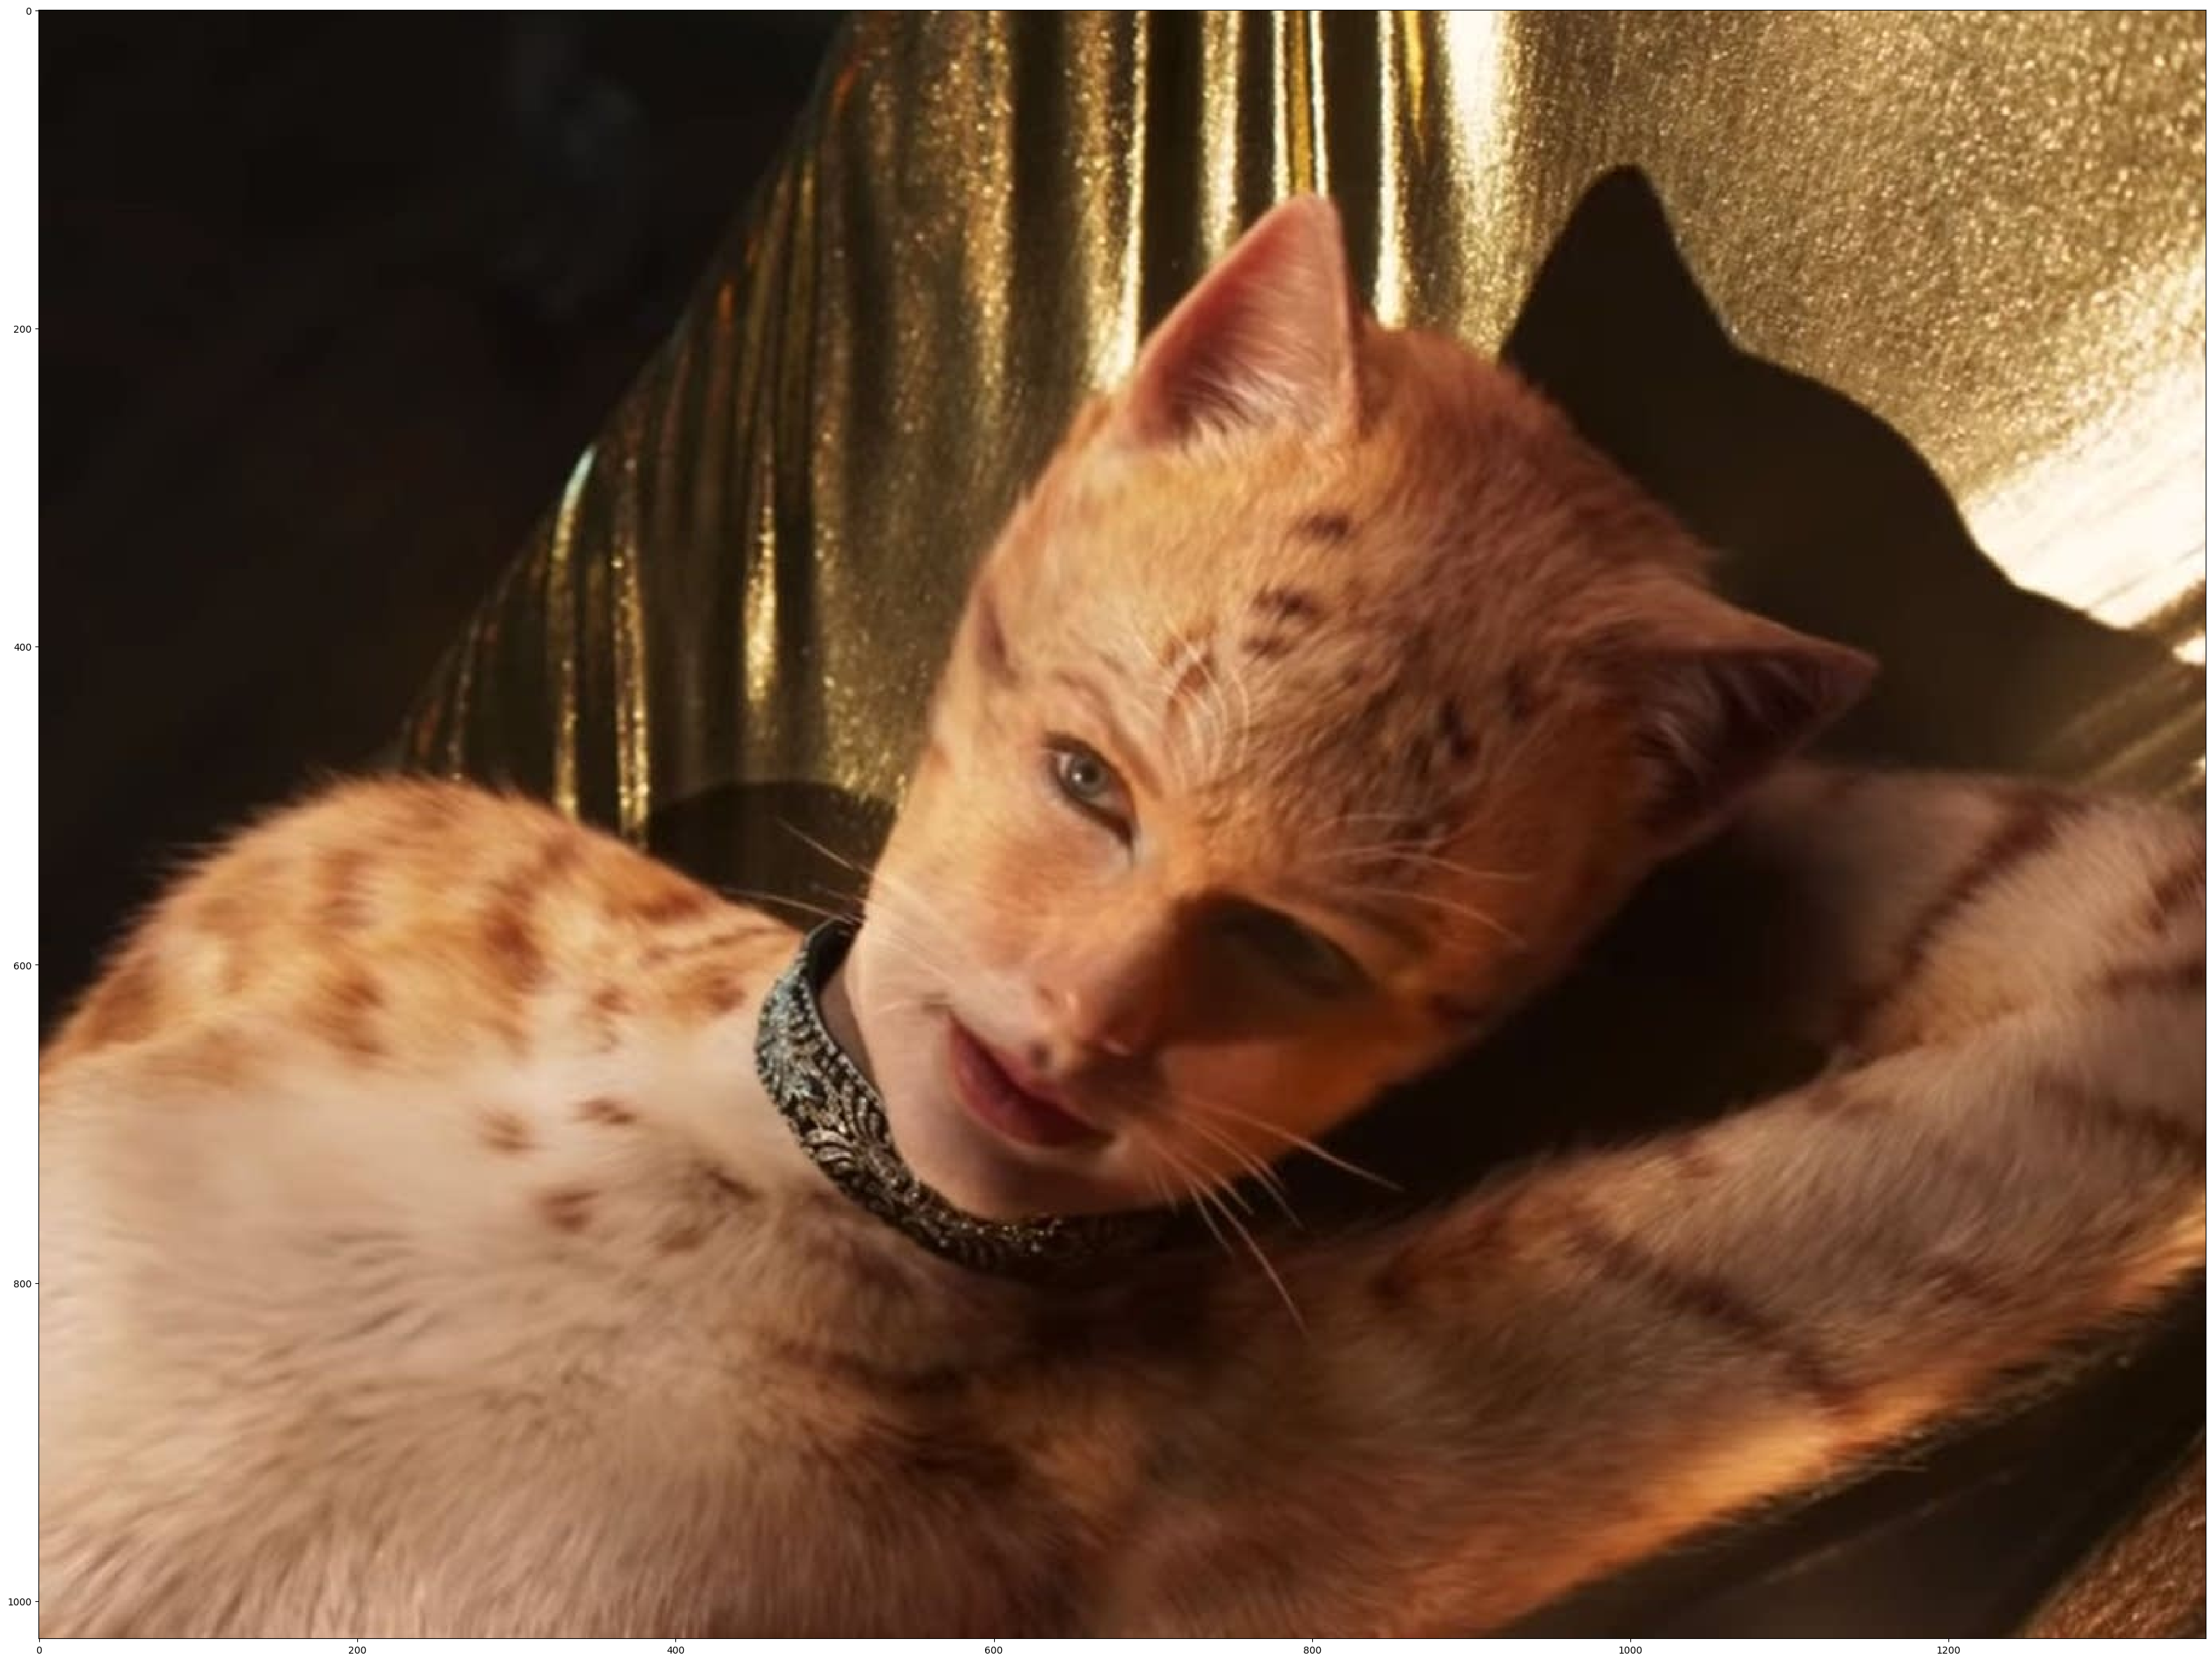

In [14]:
## START CODE HERE ##
my_image = "not_quite_a_cat.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
## END CODE HERE ##

fname = "images/" + my_image
image = Image.open(fname)
my_image = np.array(image.resize((num_px, num_px))).reshape((1, num_px*num_px*3)).T
my_image = my_image/255.
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

<a id="part2"></a>
## Part 2: Full Machine Learning Project

Now you will use all you know about building and training neural networks in an "idea, code, experiment" cycle on a data set.

### 2.1 - Find a dataset (or datasets)

Find an appropriate dataset to work with. Some places to look:
- [Kaggle](https://www.kaggle.com/datasets) 
- [University of California, Irvine Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php)

You can choose just one, or more than one if you'd like to. Think carefully of the type of task you are trying to accomplish (e.g., classification, regression, etc.). Spend some time analyzing and processing the data. For example, decide how to split the data; should you have separate train, dev, and test sets? Does the data need to be cleaned or adjusted? How should the data be normalized? Any other considerations or adjustments needed for the data?

Clearly indicate where you found the dataset(s) you are working with.

Show the work you have done analyzing and processing the data in Python boxes in this notebook. There should also be associated markdown boxes discussing what you have observed and what decisions you have made.




In [4]:
# Your work for analyzing and processing the data
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


# data source: https://www.webassign.net/statistics1/dataset_hub/datasethub.html

# import various CSV data using panda
wine = pd.read_csv(r".\datasets\wine\wine_quality.csv")


# this machine learning model will be using various chemical compounds to predict the quality of the wine
# excludes the type of wine as type cannot be transfered to numeric value
# I choose this dataset since it gives the most amount of numerical data compared to the different datasets I found online


# I think there might be a strong association between the chemical compounds inside the wine and the quality of the wine
# Given the amount of numerical data for each data and the dataset amount, 
# I believe the dataset will provide a strong training set 

x_wine = np.array(wine[['fixed acidity'
                        ,'volatile acidity'
                       ,'citric acid'
                       ,'residual sugar'
                       ,'chlorides'
                       ,'free sulfur dioxide'
                       ,'total sulfur dioxide'
                       ,'density'
                       ,'pH'
                       ,'sulphates'
                       ,'alcohol']])

y_wine = np.array(wine['quality'])



# convert y labels to categorical, and convert the range of label from 3 - 8 to 0 to 5
# separate into y_training 1 and 2 for model 1 and 2 (regression vs classification)
num_class = len(np.unique(y_wine))
y_min = np.min(y_wine)
print("y min : " + str(y_min))
y_training1 = y_wine
y_training2 = keras.utils.to_categorical(y_wine - y_min, num_class)

# normalize input
x_normalize = keras.utils.normalize(x_wine)

# split the data into training/testing data
x_train, x_test, y_train, y_test = train_test_split(x_normalize, y_training2, test_size = 0.15, random_state = 7)
print("Input and output data :")
print(x_normalize)
print("X training set shape" + str(x_normalize.shape))
print(y_training1)
print("Y training set shape" + str(y_training1.shape))
print(y_training2)
print("Y training set shape" + str(y_training2.shape))
print("Category amount : " + str(num_class))

y min : 3
Input and output data :
[[0.19515252 0.01846037 0.         ... 0.09256559 0.0147683  0.24789644]
 [0.10724124 0.01209901 0.         ... 0.04399641 0.00934924 0.134739  ]
 [0.13545665 0.01319834 0.00069465 ... 0.05661393 0.01128805 0.17018912]
 ...
 [0.05622854 0.00207613 0.0016436  ... 0.02586513 0.00397925 0.08131512]
 [0.04878972 0.00257255 0.00266126 ... 0.02962867 0.00337093 0.11354698]
 [0.05918939 0.00207163 0.00374866 ... 0.03215957 0.00315677 0.11640581]]
X training set shape(6497, 11)
[5 5 5 ... 6 7 6]
Y training set shape(6497,)
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Y training set shape(6497, 7)
Category amount : 7


### 2.2 - Build your model

Start with a basic model, show the results, and then apply whichever improvements you decide to incorporate as per below.

You have two options for building your model:
- **The difficult option**: Use the provided L-layer network code used above in Part 1 and (later) extend it to incorporate more advanced neural network improvements as given in class
- **The easier option**: Use [Keras](https://keras.io) and [TensorFlow](https://www.tensorflow.org) to build a network
	- You may *not* use any framework other than Keras/TensorFlow

Ambition will be rewarded! If you choose the easier option, you are expected to incorporate more of the potential improvements given below.

Some of the neural network improvements you can consider incorporating for either option (not an exhaustive list):
- Weight initialization methods (e.g., zeroes, random, etc.)
- Regularization: L2, dropout, etc.
- Mini-batch gradient descent
- Gradient descent optimization algorithm: momentum, RMSProp, Adam, etc.
- Batch normalization

Show the results with your model with improvements. Use markdown boxes to discuss the effect of your improvement(s) and change in accuracy.

In [16]:
# Your work for building a basic model and then applying improvements

# Start with basic setup from the lecture slides with slight adjustment to fit the data

# wine model, output layer set to 9 since wine quality in the dataset goes up to 9

# model 1:
# outside of necessary adjustment, the hyper parameters stay the same as lecture slide in this case
# input = 11, output = 1

wine1 = Sequential ()
wine1.add(Dense(11, input_shape=(11,), activation='relu'))
wine1.add(Dense(12, activation='relu'))
wine1.add(Dense(20, activation='tanh'))
wine1.add(Dense(16, activation='relu'))
wine1.add(Dense(9, activation='relu'))
wine1.add(Dense(1, activation='linear'))
# adjust optimizer and learning rate 
wine1.compile(loss='mse' , optimizer=keras.optimizers.Adam(learning_rate=0.0005), metrics=["mean_squared_error"])



# I realized I'm trying to use a regression model for a classification model
# so I build a second model to see if there will be improvement

wine2 = Sequential ()
wine2.add(Dense(11, input_shape=(11,), activation='tanh'))
wine2.add(Dense(12, activation='tanh'))
wine2.add(Dense(16, activation='tanh'))
wine2.add(Dense(24, activation='tanh'))
wine2.add(Dense(40, activation='tanh'))
wine2.add(Dense(20, activation='tanh'))
wine2.add(Dense(9, activation='tanh'))
wine2.add(Dense(num_class, activation='softmax'))
wine2.compile(loss='categorical_crossentropy' , optimizer=keras.optimizers.SGD(learning_rate = 0.00075, momentum = 1 ), metrics=["accuracy"])
print(wine2.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_62 (Dense)            (None, 11)                132       
                                                                 
 dense_63 (Dense)            (None, 12)                144       
                                                                 
 dense_64 (Dense)            (None, 16)                208       
                                                                 
 dense_65 (Dense)            (None, 24)                408       
                                                                 
 dense_66 (Dense)            (None, 40)                1000      
                                                                 
 dense_67 (Dense)            (None, 20)                820       
                                                                 
 dense_68 (Dense)            (None, 9)               

### 2.3 - Idea, Code, Experiment Cycle

Now go through a iterative process to improve your model. This will involve things like (not an exhaustive list):
- Checking whether you have a bias and/or variance problem. How will you address it? 
- Hyperparameter tuning: learning rate, # of layers, # of hidden units, activation functions, mini-batch size, etc.
- Trying any of the improvements made to the model in part 2.2 to see if it leads to better results

We want to see the progression of your model to a final version with the best results you can achieve. You don't have to show results for every single experiment you tried, but a general progression of different models at various stages of development should be included. Feel free to include discussion, diagrams, tables, and/or graphs that may summarize some of your experiments. **If you only show us the final model you've built, your mark will be minimal**.

Your discussion should also include details on the methodology you used in your experiments. For example, how did you approach hyperparameter tuning?


In [ ]:
# Your work for experiments

num_batch = 512
num_epoch = 5000

# model 1
# result = wine1.fit(x_train, y_train, epochs = num_epoch, batch_size= num_batch)
# y_pred = wine1.predict(x_test)
# score = wine1.evaluate(x_test, y_test, batch_size= num_batch)

# fitting the wine model, comment out t
result2 = wine2.fit(x_train, y_train, epochs = num_epoch, batch_size= num_batch)
y_pred2 = wine2.predict(x_test)
score2 = wine2.evaluate(x_test, y_test, batch_size= num_batch)


# 1st model 1 adjustment
# mostly follow the model setup from the keras slide given during lecture
# loss value always result in -73.4179 after 2 epoch iteration despite adjustment in layer
# adjustment in the final layer activation function gives nam value if not using relu
# result does not properly predict at all

# 2nd model 1 adjustment
# loss value started to adjust more frequently, but still ended up around -73 
# output prediction always results in 1

# 3rd model 1 adjustment
# changing learning rate, loss value change to 89.85, still output no prediction (all 0)

# 4th model 1 adjustment
# normalized data, changing optimizer and decrease layer

# 5th model 1 adjustment
# increasing epoch number to thousand digits

# 6th model 1 adjustment
# changing loss function in the compilie line from 'binary_crossentropy' to 'mse', significant improvement
# loss function decreasing at a steady pace
# output starting to resemble the expected output (x = y)

# 7th model 1 adjustment
# changing epoch to 200, batch_size=200
# loss value slowly decreasing to 0.5, but not any lower

# 9th model 1 adjustment
# adding extra layer with tanh activation, and changing other activation function on the other layer
# loss starts from 0.5 on the very first iteration, but never reached below 0.5

# 10th model 1 adjustment
# increasing epoch to 2500, increase batch size to 500, loss value starts near 0.49 (could be error), 
# but make slow to no progression to reach 0

# 11th model 1 adjustment
# increasing epoch to 3000, increase batch size to 700, procedure usually freezed halfway through the process
# tuning it back down to 2500, batch size to 500


# 12th model 1 adjustment
# increase epoch size to 5000, batch size remain 500
# change activation functions, remove tanh, model only compose of relu and linear activation function
# change metrics to mape
# loss value does not fall below 0.49


# final model 1 adjustment
# change learning rate to 0.0005
# adding extra layer with relu activation function
# adjust batch_size to 512 to fit the 2^n pattern



# added wine2 as softmax classification
# this model should categorize the result to 0 to 5 (corresponding 3 - 8)
# this model also results in the same accuracy as the 1st model's mse(~0.55)



# conclusion:
# changing the loss function gives the most significant boost, 
# as I realized the wrong loss function will not produce any logical result
# relu and tanh activiation gives the best result (accuracy ~ 0.55)
# certain combination of layer order involving tanh activation function will cause prediction to fail completely

# judging from the different combination of hyper parameters i tried (different layer and neuron quantity, learning rate
# activation function, amount of test data set vs training data set, loss function), it seems that the loss value will not 
# fall below 0.5, the accuracy of both regression and classification model is around 0.55
# which could indicate that the input features might not have strong correlation with the quality of the wine
# as I previously assume


# result plot
# plt.clf()
# fig = plt.figure()
# fig.suptitle('Actual vs Predicted')
# plt.scatter(x=y_pred, y=y_test, marker='.')
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.show()

# print("model 1 score:", score)
print("model 2 score:", score2)

Epoch 1/5000
11/11 [==============================] - 1s 3ms/step - loss: 1.8921 - accuracy: 0.0647
Epoch 2/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.7915 - accuracy: 0.0853
Epoch 3/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.6493 - accuracy: 0.3502
Epoch 4/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.5238 - accuracy: 0.3448
Epoch 5/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.4247 - accuracy: 0.4272
Epoch 6/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3595 - accuracy: 0.4317
Epoch 7/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3338 - accuracy: 0.4315
Epoch 8/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3357 - accuracy: 0.4315
Epoch 9/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3390 - accuracy: 0.4315
Epoch 10/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3329 - accuracy: 0.4315

11/11 [==============================] - 0s 3ms/step - loss: 1.3240 - accuracy: 0.4315
Epoch 83/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3248 - accuracy: 0.4315
Epoch 84/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3312 - accuracy: 0.4315
Epoch 85/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3433 - accuracy: 0.3892
Epoch 86/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3523 - accuracy: 0.3327
Epoch 87/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3519 - accuracy: 0.3327
Epoch 88/5000
11/11 [==============================] - 0s 4ms/step - loss: 1.3449 - accuracy: 0.4315
Epoch 89/5000
11/11 [==============================] - 0s 4ms/step - loss: 1.3408 - accuracy: 0.4315
Epoch 90/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3444 - accuracy: 0.4315
Epoch 91/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3491 - accuracy: 0.4315
Epoc

11/11 [==============================] - 0s 3ms/step - loss: 1.3184 - accuracy: 0.3750
Epoch 163/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3090 - accuracy: 0.3680
Epoch 164/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.2991 - accuracy: 0.4315
Epoch 165/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.2929 - accuracy: 0.4315
Epoch 166/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.2963 - accuracy: 0.4315
Epoch 167/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3028 - accuracy: 0.4315
Epoch 168/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3068 - accuracy: 0.4315
Epoch 169/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3055 - accuracy: 0.4315
Epoch 170/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3046 - accuracy: 0.4315
Epoch 171/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3074 - accuracy: 0.

11/11 [==============================] - 0s 3ms/step - loss: 1.3108 - accuracy: 0.4315
Epoch 243/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3123 - accuracy: 0.4315
Epoch 244/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3122 - accuracy: 0.4315
Epoch 245/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3120 - accuracy: 0.4315
Epoch 246/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3165 - accuracy: 0.4315
Epoch 247/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3241 - accuracy: 0.4315
Epoch 248/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3299 - accuracy: 0.4315
Epoch 249/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3299 - accuracy: 0.4315
Epoch 250/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3252 - accuracy: 0.4315
Epoch 251/5000
11/11 [==============================] - 0s 3ms/step - loss: 1.3212 - accuracy: 0.

**Grading**: 
- Part 1 code for L_layer_model(): **10 marks**
- Part 2:
  - Dataset choice and analysis: **10 marks**
  - Building your model:
    - Basic model: **5 marks**
    - Implementing improvements to model: **15 marks**
  - Idea, Code, Experiment Cycle: **20 marks**

**Total** for project: **60 marks**

**Submission**: Submit a zip file containing all of the files/folders for your project. Make sure all files are included; do not assume we have certain files already.